# KNNFuzz Wrap-up & How to use it

## Structure of the code
```txt
FuzzSIM/
│── fuzz/            
│   ├── choquet/
│   │   ├── __init__.py
│   │   ├── choquet.py
│   │   ├── classic.py      
│   │   ├── d_choquet.py  
│   │   ├── linear_d_choquet.py  
│   ├── src/     
│   │   ├── __init__.py
│   │   ├── base.py 
│   │   ├── knn.py              
│   │   ├── norm.py              
│   │   ├── sim.py              
│   ├── __init__.py
│   ├── set.py              
│   ├── dataloader.py              
│   ├── eval.py    
│   ├── optim.py
│   ├── utils.py 
│── scripts/                
│   ├── setup_env.sh     
│── __init__.py
│── requirements.txt
│── LICENSE
│── README.md                      
```
### About Choquet Integral
Currently, we've implemented 3 methods for computing the Choquet integral:
- `classic.py`: Classic fuzzy measure.
- `d_choquet.py`: d-Choquet integral. The formula is given by:
    $$
    \mathbb{C}_{\nu, \delta}(X)=\sum_{i=1}^{n} \delta(X(\sigma(i)), X(\sigma(i-1))) \cdot \nu(\{\sigma(i), ..., \sigma(n)\})
    $$
- `linear_d_choquet.py`: Linear d-Choquet integral.
    $$
    \mathbb{C}[X]=\sum^n_{i=1}\mu_i\left[\sum_{x_j\leq x_i} \delta(x_j, \max\{x_k:x_k\leq x_j\}_{j\neq k})\right]+\sum_{i<j}\mu_{ij}\left[\sum_{x_k\leq\min\{x_i,x_j\}}\delta\left(x_k, \max\{x_h: x_h\leq x_k\}_{h\neq k}\right)\right]
    $$

The `choquet.py` file contains the Choquet integral class, which can be used to compute the Choquet integral using any of the above methods.

### About FuzzSIM
FuzzSIM is a class implementing different methods for computing the similarity between sets. We differ 3 levels of similarity, which are: 

- Similarity level 1: 

    $$
    \mathbf{S}_1^{\nu, \delta}(X, Y)=\frac{\mathbb{C}_{\nu, \delta}(X\cap Y)}{\mathbb{C}_{\nu, \delta}(X\backslash Y) + \mathbb{C}_{\nu, \delta}(Y\backslash X) + \mathbb{C}_{\nu, \delta}(X\cap Y)}
    $$

### About KNNFuzz
KNNFuzz is a variant of the KNN algorithm. The idea is instead of using the standard distance metric, we use the Choquet integral to compute the similarity between sets. Using similarity to explain the ressemblance between sets makes it easier to understand the results of the algorithm. The KNNFuzz algorithm is implemented in the `knn.py` file.

---


## Setup environment
Simplest way to setup the environment is to run the `setup_env.sh` script, you will need to switch to the newly created kernel to use it. 

Otherwise, to be more safe, you can run the following commands to install the required packages:
```bash
# Create a conda environment with compatible python version (3.10)
conda create -n fuzzsim python=3.10 -y

# Activate the environment
conda activate fuzzsim

# Optional: upgrade pip
pip install --upgrade pip

# Install other dependencies
pip install -r requirements.txt
```

In [ ]:
# environment setup 
!chmod +x scripts/setup_env.sh
!./scripts/setup_env.sh

---
## Main demo

### Import libraries

In [2]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [3]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

### Dataloader

There are 2 ways to prepare data for the KNNFuzz algorithm:
1. Use `dynamic_generate_positive_gaussian_data` to dynamically generate a dataset of positive Gaussian data.
2. Use specific datasets, such as `iris`, `penguins`, etc.

The following cell with allow us to generate a complete positive Gaussian dataset, with 3 dimensions, 3 labels, and 100 points per class, using seed 42 for reproducibility. We use `batch_norm` to normalize the data to [0, 1] range.

In [4]:
data, labels = dynamic_generate_positive_gaussian_data(
    dim=3,
    nb_classes=3,
    nb_points_per_class=100,
    seed=42
)
data = batch_norm(data)
data[:5]

array([[0.        , 1.        , 0.01959192],
       [1.        , 0.        , 0.4070175 ],
       [0.        , 0.38090406, 1.        ],
       [0.6965442 , 0.        , 1.        ],
       [0.        , 1.        , 0.99405304]])

As we can see, our generated dataset is well normalized and ready to be used with the KNNFuzz algorithm. 

Or, to use the `iris` dataset, you can run the following cell: 

In [5]:
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

To generated train-test dataset and labels for cross-validation, we can use the `dataloader` module. The following cell will generate a train-test split with 80% of the data for training and 20% for testing, using the `iris` dataset as an example.

After the execution, we should obtain 80% of the data from each class for training and 20% for testing, with the labels corresponding to the classes of the data points.

In [6]:
train_data, train_labels, test_data, test_labels = crossval((data, labels))
print("Original data shape:", data.shape)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Original data shape: (150, 4)
Train data shape: (120, 4)
Test data shape: (30, 4)


### Base functions

In [7]:
# To enumerate all the possible combinations of the choquet capacity
enumerated_data = enumerate_permute_unit(data[0])
print("Enumerated data shape:", len(enumerated_data))
print("Enumerated data:", enumerated_data)

Enumerated data shape: 16
Enumerated data: [[], [3], [2], [1], [0], [3, 2], [3, 1], [3, 0], [2, 1], [2, 0], [1, 0], [3, 2, 1], [3, 2, 0], [3, 1, 0], [2, 1, 0], [3, 2, 1, 0]]


In [8]:
# To generate the choquet capacity from the enumerated data
mu=generate_capacity(enumerate_permute_unit(data[0]))
print("Generated capacity shape:", len(mu))
for i in range(len(mu)):
    print(f"mu[{i}]: {mu[i].mu}")

Generated capacity shape: 16
mu[0]: 0
mu[1]: 0.015966252220214194
mu[2]: 0.17336465350777208
mu[3]: 0.18223608778806233
mu[4]: 0.20794166286818883
mu[5]: 0.230893825622149
mu[6]: 0.24102546602601171
mu[7]: 0.3854165025399161
mu[8]: 0.3910606075732408
mu[9]: 0.4251558744912447
mu[10]: 0.5677003278199915
mu[11]: 0.6099966577826209
mu[12]: 0.6832635188254582
mu[13]: 0.7553614103176525
mu[14]: 0.8331949117361643
mu[15]: 1


### Choquet calculation

In [9]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='classic', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 0.43371171536979775
Choquet capacity for data point 1: 0.41682532077983125
Choquet capacity for data point 2: 0.4317424845627137
Choquet capacity for data point 3: 0.448082474257393
Choquet capacity for data point 4: 0.4448033862878179


In [10]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='d_choquet', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 1.8553558588027954
Choquet capacity for data point 1: 1.742722511291504
Choquet capacity for data point 2: 1.8459892272949219
Choquet capacity for data point 3: 1.8170249462127686
Choquet capacity for data point 4: 1.9023610353469849


In [11]:
for i in range(5):
    choquet = Choquet(X=data[i], mu=mu, version='linear', p=1, q=1)
    print(f"Choquet capacity for data point {i}: {choquet.choquet}")

Choquet capacity for data point 0: 0.6818413776822754
Choquet capacity for data point 1: 0.6430559017197736
Choquet capacity for data point 2: 0.677780510004403
Choquet capacity for data point 3: 0.6983916228657666
Choquet capacity for data point 4: 0.704008640957595


### Similarity calculation

In [12]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S1(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

Similarity score for data points 0 and 1: 0.5332819257721103
Similarity score for data points 1 and 9: 0.5203327457868262
Similarity score for data points 2 and 1: 0.5320840434223979
Similarity score for data points 3 and 9: 0.5309091517276975
Similarity score for data points 4 and 3: 0.551334223750841


In [13]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S2(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

# S2 is the best similarity measure for the choquet capacity (as observed)

Similarity score for data points 0 and 7: 0.5174636984079782
Similarity score for data points 1 and 6: 0.5143621941642659
Similarity score for data points 2 and 8: 0.5140544272981115
Similarity score for data points 3 and 7: 0.5136937061702225
Similarity score for data points 4 and 4: 1.0


In [14]:
for i in range(5):
    y_idx = np.random.randint(0, 10)
    sim = S3(X=data[i], Y=data[y_idx], mu=mu)
    print(f"Similarity score for data points {i} and {y_idx}: {sim.score()}")

Similarity score for data points 0 and 1: 0.6210029040617058
Similarity score for data points 1 and 4: 0.6247215285754986
Similarity score for data points 2 and 7: 0.6351805307188133
Similarity score for data points 3 and 9: 0.6211183598405766
Similarity score for data points 4 and 8: 0.6346993591555544


### KNNFuzz sample usage

In [15]:
KNN = KNNFuzz(input_dimension=4, mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1)
KNN.train(data, labels)

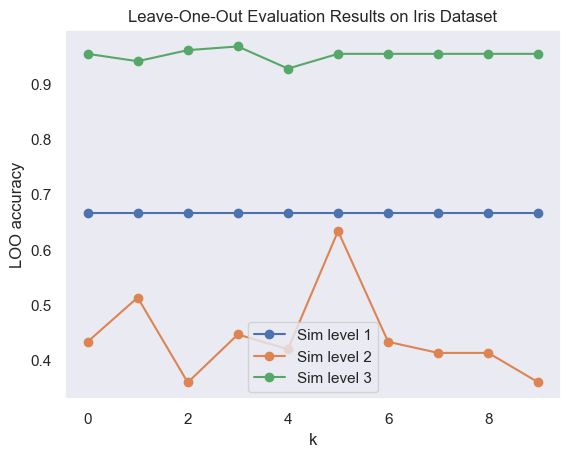

In [16]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute_unit(data[0]))

    # print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l1.append(res)
    # print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l2.append(res)
    # print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l3.append(res)
    # print(f"SimLevel3: {res}\n")

    toc = time.time()
    # print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results on Iris Dataset")
plt.grid()
plt.legend()

---

## Mobïus approach
The Mobïus approach is a method for computing the Choquet integral using the Mobïus transform. Instead of using directly the capacities, we use a Mobïus for LOO, and convert it to capacities in the end. 

In [ ]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 10

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[i], lst_mobius[j])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 65
Test Möbius measures completed!
Total number of capacities: 65


In [18]:
for i in range(5):
    mobius = lst_mobius[i]
    tmp = [mobius[j].mu for j in range(len(mobius))]
    print(f"Mobius {i + 1}: {tmp}")

Mobius 1: [0.6064290596595899, 0.009197051616629648, 0.1014715428660321, 0.6635017691080558, 0.005061583846218687, 0.16080805141749865, 0.5487337893665861, 0.6918951976926933, 0.6519612595026005, 0.22426930946055978]
Mobius 2: [0.7121792213475359, 0.23724908749680007, 0.3253996981592677, 0.7464914051180241, 0.6496328990472147, 0.8492234104941779, 0.6576128923003434, 0.5683086033354716, 0.09367476782809248, 0.3677158030594335]
Mobius 3: [0.26520236768172545, 0.24398964337908358, 0.9730105547524456, 0.3930977246667604, 0.8920465551771133, 0.6311386259972629, 0.7948113035416484, 0.5026370931051921, 0.5769038846263591, 0.4925176938188639]
Mobius 4: [0.1952429877980445, 0.7224521152615053, 0.2807723624408558, 0.02431596643145384, 0.6454722959071678, 0.17711067940704894, 0.9404585843529143, 0.9539285770025874, 0.9148643902204485, 0.3701587002554444]
Mobius 5: [0.015456616528867428, 0.9283185625877254, 0.42818414831731433, 0.9666548190436696, 0.9636199770892528, 0.8530094554673601, 0.29444889

In [19]:
for i in range(5):
    mobius = capacities_list[i]
    tmp = [mobius[j].mu for j in range(len(mobius))]
    print(f"Mobius {i + 1}: {tmp}")

# All different capacities

Mobius 1: [np.float64(0.0), np.float64(0.1655404479011839), np.float64(0.00251057237402476), np.float64(0.027699273950849666), np.float64(0.18111991549849293), np.float64(0.16943271009307917), np.float64(0.23713642573477992), np.float64(0.4964513996690287), np.float64(0.21908048024703522), np.float64(0.3616001237156007), np.float64(0.2700392799895786), np.float64(0.429899321848836), np.float64(0.6783132977040071), np.float64(0.6292674680428607), np.float64(0.6393901221288472), np.float64(1.0)]
Mobius 2: [np.float64(0.0), np.float64(0.1367606128550462), np.float64(0.04555922109601874), np.float64(0.062486886459429666), np.float64(0.1433496218294558), np.float64(0.30706960302800124), np.float64(0.3623248688708126), np.float64(0.4063924112442234), np.float64(0.21717907655150231), np.float64(0.2068973186815967), np.float64(0.27644940610376445), np.float64(0.6417668280398217), np.float64(0.5946898771733006), np.float64(0.7025695650748688), np.float64(0.4491300719519592), np.float64(1.0)]
Mo

In [20]:
mobius = lst_mobius[0]
print("Möbius:")
for i in range(len(mobius)):
    print(f"Mobius of {mobius[i].X} is {mobius[i].mu:.3f}")

capacity = capacities_list[0]
print("\nDerived Capacity:")
for c in capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Möbius:
Mobius of [0] is 0.606
Mobius of [1] is 0.009
Mobius of [2] is 0.101
Mobius of [3] is 0.664
Mobius of [0, 1] is 0.005
Mobius of [0, 2] is 0.161
Mobius of [0, 3] is 0.549
Mobius of [1, 2] is 0.692
Mobius of [1, 3] is 0.652
Mobius of [2, 3] is 0.224

Derived Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.166
Capacity of [1] is 0.003
Capacity of [2] is 0.028
Capacity of [3] is 0.181
Capacity of [0, 1] is 0.169
Capacity of [0, 2] is 0.237
Capacity of [0, 3] is 0.496
Capacity of [1, 2] is 0.219
Capacity of [1, 3] is 0.362
Capacity of [2, 3] is 0.270
Capacity of [0, 1, 2] is 0.430
Capacity of [0, 1, 3] is 0.678
Capacity of [0, 2, 3] is 0.629
Capacity of [1, 2, 3] is 0.639
Capacity of [0, 1, 2, 3] is 1.000
